## Project: Algorithm for a Dog Identification App 
---

## Import Dataset

In [ ]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  
import numpy as np
from glob import glob

# load filenames for human and dog images
dog_files = np.array(glob("/data/dog_images/*/*/*"))

print('There are %d total dog images.' % len(dog_files))

### Specify Data Loaders for the Dog Dataset
Creating 3 separate data loaders for training, validation and test datasets of dog images

In [15]:
import os
import torch
from torchvision import datasets, transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 20
num_workers = 0

#write data transformations
train_transformation = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])
test_transformation = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])
valid_transformation = transforms.Compose([transforms.Resize((224, 224)),
                                           transforms.ToTensor(),
                                           transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])

#choose datasets
train_data = datasets.ImageFolder('/data/dog_images/train/', transform = train_transformation)
test_data = datasets.ImageFolder('/data/dog_images/test/', transform = test_transformation)
valid_data = datasets.ImageFolder('/data/dog_images/valid/', transform = valid_transformation)

#create the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, num_workers = num_workers, shuffle = False)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### Trying 2 types of models:
#### 1. CNN from Scratch -- without Transfer Learning!
#### 2. CNN using a pre-trained network like VGG16 or ResNet50 -- Transfer Learning!

### Model Architecture : CNN from Scratch

Create a CNN to classify dog breed.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, stride = 2, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride = 2, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, 133)
        
        self.dropout = nn.Dropout(p=0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 7*7*128)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        return x



# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [17]:
model_scratch

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)

In [18]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.01)

### Train and Validate the Model

Train and validate your model

In [19]:
import time
from workspace_utils import active_session

t0 = time.time()
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
    
    # Training 
        
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 200 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))
                
    # Validation 
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss
            
    return model


# train the model
with active_session():
    model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'model_scratch.pt')


t1 = time.time()
print('Time taken:', (t1-t0)/60, 'min')

Epoch: 1 	Batch: 1 	Training Loss: 4.884565
Epoch: 1 	Batch: 201 	Training Loss: 4.889307
Epoch: 1 	Training Loss: 4.888137 	Validation Loss: 4.884233
Validation loss decreased (inf --> 4.884233).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 4.900558
Epoch: 2 	Batch: 201 	Training Loss: 4.881875
Epoch: 2 	Training Loss: 4.880176 	Validation Loss: 4.874946
Validation loss decreased (4.884233 --> 4.874946).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 4.876992
Epoch: 3 	Batch: 201 	Training Loss: 4.870771
Epoch: 3 	Training Loss: 4.868325 	Validation Loss: 4.858646
Validation loss decreased (4.874946 --> 4.858646).  Saving model...
Epoch: 4 	Batch: 1 	Training Loss: 4.841613
Epoch: 4 	Batch: 201 	Training Loss: 4.853291
Epoch: 4 	Training Loss: 4.847832 	Validation Loss: 4.827181
Validation loss decreased (4.858646 --> 4.827181).  Saving model...
Epoch: 5 	Batch: 1 	Training Loss: 4.618516
Epoch: 5 	Batch: 201 	Training Loss: 4.829403
Epoch: 5 	Training Loss: 4.817920 	Vali

### Test the Model


In [21]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.704032


Test Accuracy: 16% (135/836)


#### The results are certainly very poor, So I am gonna now go forward and use Transfer learning to train my model using a ResNet50 pre-trained network

## Model Architecture : CNN using Transfer Learning

In [22]:
## Specify data loaders - same as earlier
loaders_for_tfl = loaders_scratch.copy()

In [23]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_tfl = models.resnet50(pretrained = True)

#since I'm not going to tune its pretrained weights
for param in model_tfl.parameters():
    param.requires_grad = False

model_tfl

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 25709686.77it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

**Given an image, this pre-trained ResNet50 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image but we only want to classify categories of different dog breeds. If we look at the [different 'classes'](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) that are present in the ImageNet dataset, on which ResNet50 is trained, we will notice that the classes corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'. This adds up a total of 133 distinct dog breeds that can be identified by this network.**

**Therefore, I am gonna change the output of the last fully connected layer of this network(named: model_tfl_fc) which takes the flatten input from the last CNN + Average pooling layer and outputs 1000 class scores orinially with a linear layer which outputs just 133 possible class scores, one for each dog breed.**

In [24]:
model_tfl.fc = nn.Linear(2048, 133, bias = True)

if use_cuda:
    model_tfl = model_tfl.cuda()

In [25]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_tfl.fc.parameters(), lr = 0.001)

### Train and Validate the Model

Train and validate your model

In [26]:
# train the model
with active_session():
    model_transfer= train(30, loaders_for_tfl, model_tfl, optimizer_transfer, criterion_transfer, use_cuda,'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Batch: 1 	Training Loss: 4.963164
Epoch: 1 	Batch: 201 	Training Loss: 3.085524
Epoch: 1 	Training Loss: 2.510674 	Validation Loss: 0.938162
Validation loss decreased (inf --> 0.938162).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 1.702270
Epoch: 2 	Batch: 201 	Training Loss: 1.276527
Epoch: 2 	Training Loss: 1.254719 	Validation Loss: 0.691680
Validation loss decreased (0.938162 --> 0.691680).  Saving model...
Epoch: 3 	Batch: 1 	Training Loss: 0.925677
Epoch: 3 	Batch: 201 	Training Loss: 1.081106
Epoch: 3 	Training Loss: 1.090507 	Validation Loss: 0.725621
Epoch: 4 	Batch: 1 	Training Loss: 0.998676
Epoch: 4 	Batch: 201 	Training Loss: 1.001803
Epoch: 4 	Training Loss: 1.019045 	Validation Loss: 0.639802
Validation loss decreased (0.691680 --> 0.639802).  Saving model...
Epoch: 5 	Batch: 1 	Training Loss: 0.320214
Epoch: 5 	Batch: 201 	Training Loss: 0.914422
Epoch: 5 	Training Loss: 0.934424 	Validation Loss: 0.693887
Epoch: 6 	Batch: 1 	Training Loss: 1.087374
Ep

### Test the Model

In [27]:
test(loaders_for_tfl, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.580505


Test Accuracy: 81% (684/836)


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [28]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_for_tfl['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])
    image = transform(image).unsqueeze(0)
    my_model = model_transfer.cpu()
    my_model.eval()
    output = my_model(image)
    label_id = torch.argmax(output)
    return class_names[label_id]

## Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a dog or not. We could make it something as:
- if a dog is detected in the image, return the predicted breed.
- if no dog is detected in the image, provide output that indicates an error.

In [29]:
def run_app(img_path):
    if dog_detector(img_path):
        print('A dog is detected')
        image = Image.open(img_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        breed = predict_breed_transfer(img_path)
        print("It's most likely a {0}".format(breed))
        
    else:
        print("Sorry, That's nothing!")
        image = Image.open(img_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
    print()


---
## Test Your Algorithm

You're not from Animal kingdom, just a human!


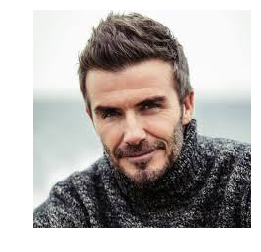

You also look like a cute Australian cattle dog

You're not from Animal kingdom, just a human!


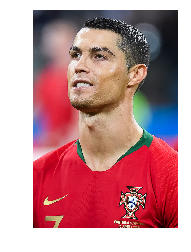

You also look like a cute Xoloitzcuintli

Sorry, That's nothing!


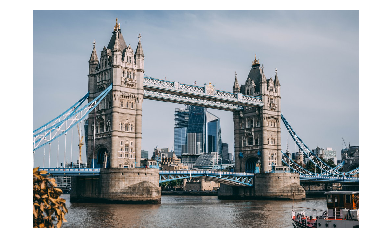


A dog is detected


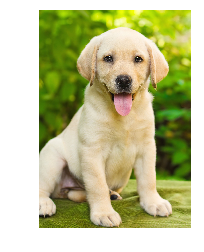

It's most likely a Labrador retriever

You're not from Animal kingdom, just a human!


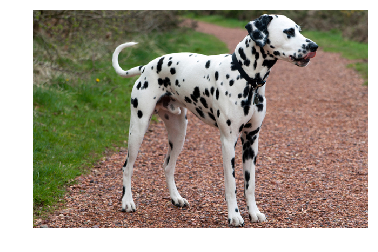

You also look like a cute Dalmatian

A dog is detected


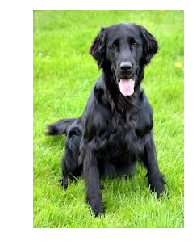

It's most likely a Flat-coated retriever



In [30]:
No_dog_files = ['imgtestapp/davidBeck.jpg', 'imgtestapp/ronaldo.jpg', 'imgtestapp/bridge.jpg']

dog_files = ['imgtestapp/labra.jpg', 'imgtestapp/dalmation.jpg', 'imgtestapp/flat_retriever.jpg']

for file in np.hstack((No_dog_files[:3], dog_files[:3])):
    run_app(file)